# **Waze Project: User Churn**

**STAGE 5: Random Forest and GBM Models**

Your team is close to completing their user churn project. Previously, you completed a project proposal, and used Python to explore and analyze Waze’s user data, create data visualizations, and conduct a hypothesis test. Most recently, you built a binomial logistic regression model based on multiple variables.

Leadership appreciates all your hard work. Now, they want your team to build a machine learning model to predict user churn. To get the best results, your team decides to build and test two tree-based models: random forest and XGBoost.

Your work will help leadership make informed business decisions to prevent user churn, improve user retention, and grow Waze’s business.


The team has completed a project proposal, used Python to explore Waze’s user data and conducted a hypothesis test, and built a binomial logistic regression model. Now, at stage 5, two tree-based machine learning models (random forest and a gradient boosting machine) will be developed and their performances compared.

Task for **Stage 5**: build and evaluate two tree-based models and determine whether the available data is sufficient for predicting user churn.

*This stage has three parts:*

**Part 1:** Feature engineering and data preparation for modelling

**Part 2:** Model construction and evaluation

**Part 3:** Interpret results for stakeholders


## **Part 1: Feature Engineering & Data Preparation**

### Package and data imports


In [1]:
# Import functional packages for data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, \
RocCurveDisplay, PrecisionRecallDisplay

from xgboost import XGBClassifier
from xgboost import plot_importance

# Pickle module
import pickle as pkl

# Remove column view limitation
pd.set_option('display.max_columns', None)

In [2]:
# Import dataset
df0 = pd.read_csv('waze_dataset.csv')

In [3]:
# Inspect the first five rows
df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


### Feature engineering

The extracted features used in the logistic regression model proved useful:

* `km_per_driving_day`
* `professional_driver`

After liasing with the client's contact, additional features that will be extracted are:

* `percent_sessions_in_last_month`
* `total_sessions_per_day`
* `km_per_hour`
* `km_per_drive`
* `percent_of_sessions_to_favorite`

To begin, a copy of the DataFrame `df0` is made to preserve the original data.

In [4]:
# Copy the df0 dataframe
df = df0.copy()
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [5]:
# Generate summary information on df0
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


**`km_per_driving_day`**

Represents the mean number of kilometers driven on each driving day in the last month for each user.


In [6]:
# reate `km_per_driving_day` feature
df0["km_per_driving_day"] = df0["driven_km_drives"] / df0["driving_days"]

# Get descriptive stats
df0.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,1.499900e+04
mean,7499.000000,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879,inf
std,4329.982679,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036,NaN
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,3.022063e+00
25%,3749.500000,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000,1.672804e+02
50%,7499.000000,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000,3.231459e+02
75%,11248.500000,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000,7.579257e+02
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000,inf


In [7]:
# Convert infinite values to zero
df0.replace(to_replace=np.inf, value=0, inplace=True)

# Validate
df0.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,7499.000000,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879,578.963113
std,4329.982679,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036,1030.094384
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000,136.238895
50%,7499.000000,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000,272.889272
75%,11248.500000,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000,558.686918
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000,15420.234110


**`professional_driver`**

Create a binary feature `professional_driver` that is a 1 for users who had 60 or more drives *and* drove on 15+ days in the last month.

In [8]:
# Create `professional_driver` feature
x = df0["drives"]
y = df0["driving_days"]
condition = (x >= 60) & (y >= 15)
df0["professional_driver"] = np.where(condition, 1, 0)

df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,professional_driver
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,1
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,1


**`percent_sessions_in_last_month`**

Create a feature that represents the percentage of each user's total sessions that were logged in their last month of use.

In [9]:
# Create `percent_sessions_in_last_month` feature
df0["percent_sessions_in_last_month"] = df0["sessions"] / df0["total_sessions"]

# Get descriptive stats
df0["percent_sessions_in_last_month"].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

**`total_sessions_per_day`**

Create a column that represents the mean number of sessions per day since onboarding.

In [10]:
# Create `total_sessions_per_day` feature
df0["total_sessions_per_day"] = df0["total_sessions"] / df0["n_days_after_onboarding"]

In [11]:
# Get descriptive stats
df0["total_sessions_per_day"].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

**`km_per_hour`**

Create a column representing the mean kilometers per hour driven in the last month.

In [12]:
# Create `km_per_hour` feature
df0["km_per_hour"] = df0["driven_km_drives"] / (df0["duration_minutes_drives"]/60)

# Get descriptive stats
df0["km_per_hour"].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

**`km_per_drive`**

Create a column representing the mean number of kilometers per drive made in the last month for each user.

In [13]:
# Create `km_per_drive` feature
df0["km_per_drive"] = df0["driven_km_drives"] / df0["drives"]

# Get descriptive stats
df0["km_per_drive"].describe()

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

In [14]:
# Convert infinite values to zero
df0["km_per_drive"].replace(to_replace=np.inf, value=0, inplace=True)

# Validate
df0["km_per_drive"].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

**`percent_of_sessions_to_favorite`**

Create a new column that represents the percentage of total sessions that were used to navigate to one of the users' favorite locations. Then, print descriptive statistics for the new column.

This serves as a proxy representation for the percent of overall drives that are to a favorite location. This must be calculated from total session rather than total drives since onboarding given that the latter is not available in the data set.

In [15]:
# Create `percent_of_sessions_to_favorite` feature
df0["percent_of_sessions_to_favorite"] = (df0["total_navigations_fav1"] + df0["total_navigations_fav1"]) / df0["total_sessions"]

# Get descriptive stats
df0["percent_of_sessions_to_favorite"].describe()

count    14999.000000
mean         2.737632
std         17.209993
min          0.000000
25%          0.094414
50%          0.843515
75%          2.563099
max       1509.208146
Name: percent_of_sessions_to_favorite, dtype: float64

### Missing values

Since we know from previous EDA that there is no evidence of a non-random cause of the 700 missing values in the `label` column, and because these observations comprise less than 5% of the data, the rows with missing data will be dropped.

In [16]:
# Drop rows with missing values
df0.dropna(inplace=True)

df0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14299 entries, 0 to 14998
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               14299 non-null  int64  
 1   label                            14299 non-null  object 
 2   sessions                         14299 non-null  int64  
 3   drives                           14299 non-null  int64  
 4   total_sessions                   14299 non-null  float64
 5   n_days_after_onboarding          14299 non-null  int64  
 6   total_navigations_fav1           14299 non-null  int64  
 7   total_navigations_fav2           14299 non-null  int64  
 8   driven_km_drives                 14299 non-null  float64
 9   duration_minutes_drives          14299 non-null  float64
 10  activity_days                    14299 non-null  int64  
 11  driving_days                     14299 non-null  int64  
 12  device                 

### Outliers

We know from previous EDA that many columns have outliers. However, since tree-based models are resilient to outliers, there is no need to make any imputations.

### Variable encoding

#### Dummying features

To use `device` as a categorical X variable, it needs to be converted to binary values. A new binary column named `device2` is created that encodes devices as:

* `Android` -> `0`
* `iPhone` -> `1`

In [17]:
# Create new `device2` variable
df0["device2"] = np.where(df0["device"]=="Android", 0, 1)

df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,professional_driver,percent_sessions_in_last_month,total_sessions_per_day,km_per_hour,km_per_drive,percent_of_sessions_to_favorite,device2
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,1,0.953670,0.130381,79.430298,11.632058,1.401862,0
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0,0.406856,0.266854,260.389902,128.186173,0.116245,1
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0,0.841186,0.051121,113.953460,32.201567,0.000000,0
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0,0.724968,4.505948,93.351141,22.839778,9.528146,1
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,1,0.499266,0.107713,194.342970,58.091206,1.973289,0


#### **Target encoding**

The target variable `label` is also categorical, so a new column `label2` is created that assigns a `0` for retained users and a `1` for churned users.

In [18]:
# Create binary `label2` column
df0["label2"] = np.where(df0["label"]=="retained", 0, 1)

df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,professional_driver,percent_sessions_in_last_month,total_sessions_per_day,km_per_hour,km_per_drive,percent_of_sessions_to_favorite,device2,label2
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,1,0.953670,0.130381,79.430298,11.632058,1.401862,0,0
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0,0.406856,0.266854,260.389902,128.186173,0.116245,1,0
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0,0.841186,0.051121,113.953460,32.201567,0.000000,0,0
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0,0.724968,4.505948,93.351141,22.839778,9.528146,1,0
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,1,0.499266,0.107713,194.342970,58.091206,1.973289,0,0


### Feature selection

Tree-based models handle multicollinearity well. So, the only feature that is dropped is `ID`.

In [19]:
# Drop `ID` column
df0.drop(columns="ID", axis=1, inplace=True)

df0.head()

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,professional_driver,percent_sessions_in_last_month,total_sessions_per_day,km_per_hour,km_per_drive,percent_of_sessions_to_favorite,device2,label2
0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,1,0.953670,0.130381,79.430298,11.632058,1.401862,0,0
1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0,0.406856,0.266854,260.389902,128.186173,0.116245,1,0
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0,0.841186,0.051121,113.953460,32.201567,0.000000,0,0
3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0,0.724968,4.505948,93.351141,22.839778,9.528146,1,0
4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,1,0.499266,0.107713,194.342970,58.091206,1.973289,0,0


### Evaluation metric

An evaluation metric must be chosen before model construction. The class balance will be inspected to determine whether precision, recall, or F1 is the best metric on which to train the models.

In [20]:
# Get class balance of 'label' column
df0["label2"].value_counts(normalize=True)

label2
0    0.822645
1    0.177355
Name: proportion, dtype: float64

This is a somewhat unbalanced data set where approximately 18% of the users churned. No class rebalancing is required.

Accuracy is not a reliable indication of a model's performance on a data set where there are only 18% of responses. There are also low risks and costs associated with making false positive predictions. Thus, the models will be trained based on their **recall** score.

## **Part 2: Model Construction & Evaluation**

**MODEL SELECTION PROCESS**

In our data set with 14'299 records, a 0.6/0.2/0.2 split would result in about 8579 observations in the training set and 2860 observations in each of the validation and testing sets. Considering the churn rate of 18%, this works out to having about 1543/515/515 responses in the respective splits.

1. Split the data into train/validation/test sets (60/20/20)

2. Fit models and tune hyperparameters on the training set

3. Perform final model selection on the validation set

4. Assess the champion model's performance on the test set

### Split data: train/validate/test

1. Define variable `X` as a subset of the DataFrame with predictor variables (excl. `device`).

2. Define a variable `y` that isolates the target variable (`label2`).

3. Split the data 80/20 into an interim training set and a test set, stratified by `y` with a random state of 42.

4. Split the interim training set 75/25 into training and validation sets (stratified by `y_tr`) yielding a final ratio of 60/20/20 for training/validation/testing sets.

In [21]:
# Subset X variables
unused = ["device", "label", "label2"]
X = df0.drop(columns=unused, axis=1)

# Isolate y variable
y = df0["label2"]

# Split into interim train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split interim train set into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, stratify=y_tr, random_state=42)

In [22]:
# Verify the number of samples in the partitioned data
print(f"X_train: {X_train.shape[0]}\n"
      f"y_train: {y_train.shape[0]}\n\n"
      f"X_val: {X_val.shape[0]}\n"
      f"y_val: {y_val.shape[0]}\n\n"
      f"X_test: {X_test.shape[0]}\n"
      f"y_test: {y_test.shape[0]}")

X_train: 8579
y_train: 8579

X_val: 2860
y_val: 2860

X_test: 2860
y_test: 2860


This is consistent with expectations.

### Model construction: random forest

We begin with using `GridSearchCV` to tune a random forest model.

1. Instantiate the random forest classifier `rf` and set random state to 42.

2. Create a dictionary `cv_params` with a list of values to search over for each of the following hyperparameters:

 - `max_depth`
 - `max_features`
 - `max_samples`
 - `min_samples_leaf`
 - `min_samples_split`
 - `n_estimators`

3. Define a list `scoring` of scoring metrics for GridSearch to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `rf_cv`, passing to it as arguments:

 - estimator=`rf`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv=`5`
 - refit=`recall`

The objects fit to the training data will be pickled, then fitting and pickling commented out.

In [23]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [3,6,None], 
             'min_samples_leaf': [2, 4, 10],
             'max_samples': [0.75, 1.0],
             'max_features': [0.4, 0.8, 1.0],
             'min_samples_split': [2, 10],
             'n_estimators': [75, 150, 300]
             }  

# Define a list of scoring metrics to capture
scoring = ["f1", "recall", "accuracy", "precision"]

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(estimator=rf, param_grid=cv_params, scoring=scoring, cv=5, refit="recall", n_jobs=-1)

In [24]:
# %%time
# # Fit GridSearch() object to training data
# rf_cv.fit(X_train, y_train)

In [25]:
# # Pickle the model
# with open('rf_cv_model1.pickle', 'wb') as to_write:
#     pkl.dump(rf_cv, to_write)

# Open pickled model
with open('rf_cv_model1.pickle', 'rb') as to_read:
    rf_cv = pkl.load(to_read)

In [26]:
# Examine the best average score across all the validation folds
print(f"Best Recall Score: {rf_cv.best_score_}")

Best Recall Score: 0.13402286453839515


In [27]:
# Examine the best combination of hyperparameters
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 75}

In [28]:
# Use a defined function to use `make_results()` to output all the model's scores

def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a GridSearchCV object fit to training data
        metric (string): precision, recall, f1, or accuracy

    Returns a Pandas DataFrame with F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Write an augmented variable assignment that uses the metric given as 'metric:str' argument to define metric score to fetch
    gridsearch_metric = "mean_test_"
    gridsearch_metric += metric
    
    # Get all results from the GridSearchCV and create a DataFrame
    cv_results = pd.DataFrame(data=model_object.cv_results_)
    
    # Isolate the row of the DataFrame with the max(gridsearch_metric) score
    best_estimator = cv_results[gridsearch_metric].idxmax()
    best_estimator_results = cv_results.loc[best_estimator, :]
    
    # Extract Accuracy, precision, recall, and F1 score from that row
    f1 = best_estimator_results["mean_test_f1"]
    accuracy = best_estimator_results["mean_test_accuracy"]
    recall = best_estimator_results["mean_test_recall"]
    precision = best_estimator_results["mean_test_precision"]

    # Create a table of results
    columns = ["model_name", "f1", "accuracy", "precision", "recall"]
    results_table = pd.DataFrame(columns=columns)
    
    add_best_metrics = pd.Series({"model_name": model_name, "f1": f1, "accuracy": accuracy, "precision": precision, "recall": recall})
    best_estimator_metrics = pd.DataFrame([add_best_metrics])
    
    results_table = pd.concat([results_table, best_estimator_metrics], ignore_index=True)
    return results_table


In [29]:
# Pass our fit GridSearchCV object to the above 'make_results()' function
results = make_results(model_name="rf_cv", model_object=rf_cv, metric="recall")
results

,model_name,f1,accuracy,precision,recall
0,rf_cv,0.205903,0.817228,0.452683,0.134023


Asside from the accuracy, the scores are very weak. However, the recall for the logistic regression model was only 0.08, which makes this model's recall of 0.134 67% better. Refitting the model on further tuned hyperparameters may yield a marginal improvement. But this isn't worth the resources at this stage.

### Model construction: XGBoost

We will attempt to improve the above scores by using XGBoost to run a GBM model.

1. Instantiate the XGBoost classifier `xgb` and set `objective='binary:logistic'`, and set random state to 42.

2. Create a dictionary `cv_params` of hyperparameters and their corresponding values to tune:
 - `colsample_bytree`
 - `max_depth`
 - `min_child_weight`
 - `learning_rate`
 - `n_estimators`

3. Define a list `scoring` of scoring metrics for gridsearch to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `xgb_cv` and pass to it as arguments:
 - estimator=`xgb`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv=`5`
 - refit=`recall`

The objects fit to the training data will be pickled, then code for fitting and pickling commented out.

In [30]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective="binary:logistic", random_state=42)

# Create a dictionary of hyperparameters to tune
cv_params = {'colsample_bytree': [0.5, 1.0],
             'max_depth': [4, 6, 12], 
             'min_child_weight': [2, 4, 6],
             'learning_rate': [0.01, 0.1, 0.3],
             'n_estimators': [100, 300]
             }  

# Define a list of scoring metrics for GridSearch to capture
scoring = ["f1", "precision", "recall", "accuracy"]

# Instantiate GridSearchCV object
xgb_cv = GridSearchCV(estimator=xgb, scoring=scoring, param_grid=cv_params, cv=5, refit="recall", n_jobs=-1)

In [31]:
# %%time
# # Fit GridSearch to training data
# xgb_cv.fit(X_train, y_train)

In [32]:
# # Pickle the model
# with open('xgb_cv_model1.pickle', 'wb') as to_write:
#     pkl.dump(xgb_cv, to_write)

# Open pickled model
with open('xgb_cv_model1.pickle', 'rb') as to_read:
    xgb_cv = pkl.load(to_read)

In [33]:
# Examine best score
xgb_cv.best_score_

0.1918636755823986

In [34]:
# Examine best parameters
xgb_cv.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_weight': 6,
 'n_estimators': 300}

In [35]:
# Call 'make_results()' user defined function on the GridSearch object
xgb_cv_results = make_results(model_name="xgb_cv", model_object=xgb_cv, metric="recall")
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model_name,f1,accuracy,precision,recall
0,rf_cv,0.205903,0.817228,0.452683,0.134023
0,xgb_cv,0.258205,0.804522,0.396007,0.191864


The best GBM model fit the data better than the random forest model. The recall score is more than double the recall score of the logistic regression model. It's 42% better than the random forest model's recall score, while maintaining a similar accuracy and precision score.

### Model selection

The champion model will be selected from between the best random forest model and the best XGBoost model based on their performance on the validation data set.

#### Random forest

In [36]:
# Use the best random forest model to predict on validation data
rf_cv_pred = rf_cv.best_estimator_.predict(X_val)

In [37]:
# Write a 'get_test_scores()' function to generate a table of scores from the validation data
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a Pandas DataFrame of precision, recall, f1, and accuracy scores for the model_name
    '''
    # Assign sklearn's scoring functions to variables
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)
    
    # Use scoring function variables to get values for respective scoring metrics
    table = pd.DataFrame({'model_name': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy]
                          })
    
    # Return the DataFrame
    return table

In [38]:
# Call 'get_test_scores()' on random forest model to get validation scores
rf_cv_val_scores = get_test_scores(model_name="rf_cv_validate", preds=rf_cv_pred, y_test_data=y_val)

# Append to the results table
results = pd.concat([results, rf_cv_val_scores], axis=0)
results

,model_name,f1,accuracy,precision,recall
0,rf_cv,0.205903,0.817228,0.452683,0.134023
0,xgb_cv,0.258205,0.804522,0.396007,0.191864
0,rf_cv_validate,0.225564,0.819930,0.474684,0.147929


Notice that the F1, accuracy, and precision scores were slightly stronger on the validation set. This is a good sign; the model did not overfit the training data.

#### GBM

We repeat this test on the validation data with the GBM model.

In [39]:
# Use XGBoost model to predict on validation data
xgb_cv_pred = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_cv_val_scores = get_test_scores(model_name="xgb_cv_validate", preds=xgb_cv_pred, y_test_data=y_val)

# Append to the results table
results = pd.concat([results, xgb_cv_val_scores], axis=0)
results

,model_name,f1,accuracy,precision,recall
0,rf_cv,0.205903,0.817228,0.452683,0.134023
0,xgb_cv,0.258205,0.804522,0.396007,0.191864
0,rf_cv_validate,0.225564,0.819930,0.474684,0.147929
0,xgb_cv_validate,0.233596,0.795804,0.349020,0.175542


Unlike the random forest model, the GBM model's validation scores were lower, but only very slightly. It is still the clear champion.

### Use champion model to predict on test data

The champion GBM model will predict on the test dataset. This provides us with a final indication of how we can expect it to perform on unseen data should it be deployed.

In [40]:
# Use champion GBM model to predict on test data
xgb_cv_test_pred = xgb_cv.best_estimator_.predict(X_test)

# Get test scores
xgb_cv_test_scores = get_test_scores(model_name="xgb_cv_test", preds=xgb_cv_test_pred, y_test_data=y_test)

# Append to the results table
results = pd.concat([results, xgb_cv_test_scores], axis=0)
results

,model_name,f1,accuracy,precision,recall
0,rf_cv,0.205903,0.817228,0.452683,0.134023
0,xgb_cv,0.258205,0.804522,0.396007,0.191864
0,rf_cv_validate,0.225564,0.819930,0.474684,0.147929
0,xgb_cv_validate,0.233596,0.795804,0.349020,0.175542
0,xgb_cv_test,0.267009,0.800350,0.382353,0.205128


The scores were stronger than on the validation data, and the recall stronger than the GridSearch score. This is stil within the acceptable range for performance discrepancy between CV, validation, and test scores.

### Identify optimal decision threshold

The default decision threshold for most implementations of classification algorithms&mdash;including scikit-learn's&mdash;is 0.5. With imbalanced datasets where the response class is a minority (such as is the case in this project), this threshold might not be ideal. A better decision threshold that optimises recall may be found.

Text(0.5, 1.0, 'Precision-recall curve, XGBoost model')

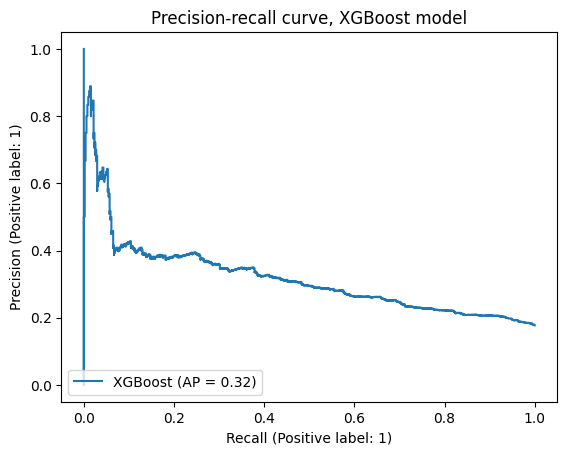

In [41]:
# Plot precision-recall curve
display = PrecisionRecallDisplay.from_estimator(
    xgb_cv.best_estimator_, X_test, y_test, name='XGBoost'
    )
plt.title('Precision-recall curve, XGBoost model')

Given the preference of a higher rate of true positives over avoiding false negatives, we can find the best recall score and evaluate overall performance. We will first check the recall at a decision threshold of 0.4.

(*Notice the very poor AP score of 0.32.*)

In [42]:
# First, get predicted probabilities on the test data
predicted_probabilities = xgb_cv.best_estimator_.predict_proba(X_test)
predicted_probabilities

array([[0.9762102 , 0.02378983],
       [0.8498308 , 0.15016921],
       [0.99420923, 0.00579075],
       ...,
       [0.945494  , 0.05450598],
       [0.9754597 , 0.02454028],
       [0.8330225 , 0.16697755]], dtype=float32)

In [43]:
# Create a list of just the second column values (probability of the target variable)
probs = [x[1] for x in predicted_probabilities]

# Create an array of new predictions that assigns a 1 to any value >= 0.4
new_preds = np.array([1 if x >= 0.4 else 0 for x in probs])
new_preds

array([0, 0, 0, ..., 0, 0, 0])

In [44]:
# Get evaluation metrics for when the threshold is 0.4
get_test_scores('XGB, threshold = 0.4', new_preds, y_test)

,model_name,precision,recall,f1,accuracy
0,"XGB, threshold = 0.4",0.363868,0.282051,0.317778,0.785315


In [45]:
# Compare these scores to the results from above
results

,model_name,f1,accuracy,precision,recall
0,rf_cv,0.205903,0.817228,0.452683,0.134023
0,xgb_cv,0.258205,0.804522,0.396007,0.191864
0,rf_cv_validate,0.225564,0.819930,0.474684,0.147929
0,xgb_cv_validate,0.233596,0.795804,0.349020,0.175542
0,xgb_cv_test,0.267009,0.800350,0.382353,0.205128


Recall increased substantially while precision and recall decreased. 

The optimal decision threshold will be explored further. From the PR curve, it appears that a recall of 0.5 would give us a precision of about 0.3. We now find the decision threshold at which these scores are achieved. A function is defined for this purpose.

In [46]:
def threshold_finder(y_test_data, probabilities, desired_recall):
    '''
    Find the threshold that most closely yields a desired recall score.

    Inputs:
        y_test_data: Array of true y values
        probabilities: The results of the `predict_proba()` model method
        desired_recall: The recall that you want the model to have

    Outputs:
        threshold: The threshold that most closely yields the desired recall
        recall: The exact recall score associated with `threshold`
    '''
    probs = [x[1] for x in probabilities]  # Isolate second column of `probabilities`
    thresholds = np.arange(0, 1, 0.001)    # Set a grid of 1,000 thresholds to test

    scores = []
    for threshold in thresholds:
        # Create a new array of {0, 1} predictions based on new threshold
        preds = np.array([1 if x >= threshold else 0 for x in probs])
        # Calculate recall score for that threshold
        recall = recall_score(y_test_data, preds)
        # Append the threshold and its corresponding recall score as a tuple to `scores`
        scores.append((threshold, recall))

    distances = []
    for idx, score in enumerate(scores):
        # Calculate how close each actual score is to the desired score
        distance = abs(score[1] - desired_recall)
        # Append the (index#, distance) tuple to `distances`
        distances.append((idx, distance))

    # Sort `distances` by the second value in each of its tuples (least to greatest)
    sorted_distances = sorted(distances, key=lambda x: x[1], reverse=False)
    # Identify the tuple with the actual recall closest to desired recall
    best = sorted_distances[0]
    # Isolate the index of the threshold with the closest recall score
    best_idx = best[0]
    # Retrieve the threshold and actual recall score closest to desired recall
    threshold, recall = scores[best_idx]

    return threshold, recall


Now we test the function to find the threshold that results in a recall score closest to 0.5.

In [47]:
# Get the predicted probabilities from the champion model
probabilities = xgb_cv.best_estimator_.predict_proba(X_test)

# Call the function to find the decision threshold where recall=0.5
threshold_finder(y_test, probabilities, 0.5)

(0.159, 0.5009861932938856)

Setting a threshold of 0.159 will result in a recall of 0.503.

This is verified by repeating the steps performed earlier for the other performance metrics. Based on the PR curve, we should expect that the precision score at a decision threshold of 0.159 is around 0.3.

In [48]:
# Create an array of new predictions that assigns a 1 to any value >= 0.159
new_preds = np.array([1 if x >= 0.159 else 0 for x in probs])

# Get evaluation metrics for when the threshold is 0.159
get_test_scores('XGB, threshold = 0.159', new_preds, y_test)

,model_name,precision,recall,f1,accuracy
0,"XGB, threshold = 0.159",0.294322,0.500986,0.370803,0.698601


### Model evaluation

Two confusion matrices will be generated; one for a decision threshold at 0.5 and another for a decision threshold at 0.159.

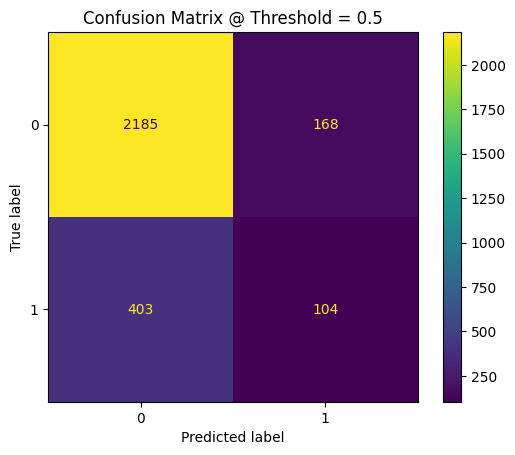

In [49]:
# Confusion matrix for threshold=0.5
# Generate array of values for confusion matrix
labels = xgb_cv.classes_
cm = confusion_matrix(y_test, xgb_cv_test_pred, labels=labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.title('Confusion Matrix @ Threshold = 0.5')
plt.show()

The model predicted about three times as many false negatives (403) than it did false positives (168), and correctly identified only 20.5% (104/507) of the users who actually churned.

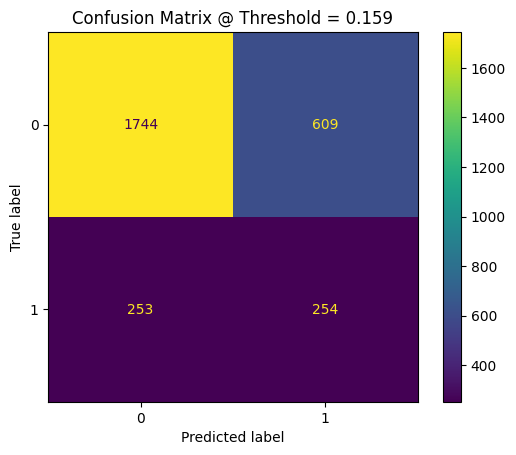

In [50]:
# Confusion matrix for threshold=0.159
# Generate array of values for confusion matrix
labels = xgb_cv.classes_
cm1 = confusion_matrix(y_test, new_preds, labels=labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=labels)
disp.plot()
plt.title('Confusion Matrix @ Threshold = 0.159')
plt.show()

At a decision threshold of 0.159, the model still missed 253 users who churned (false negatives), although it managed to capture about 50% of churned users. This is better than the 20.5% that were captured at a threshold of 0.5.

However, the cost of a higher recall score is that the model's ability to correctly predict users who do not churn is much worse; now the number of incorrectly predicted churned users is 609, up from 168.

Although the model is still below par considering all performance metrics, this improvement in recall will be presented to the client.

## **Interpretation & Key Findings**

Use the `plot_importance` function to inspect the most important features of your final model.

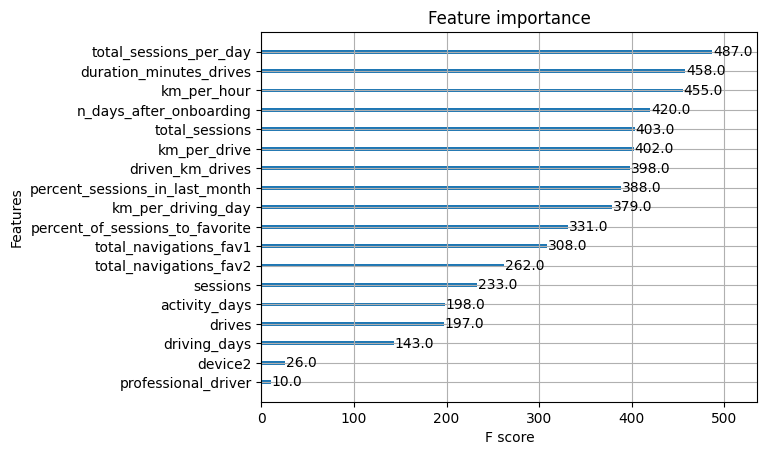

In [51]:
# Plot feature importance
plot_importance(xgb_cv.best_estimator_)
plt.show()

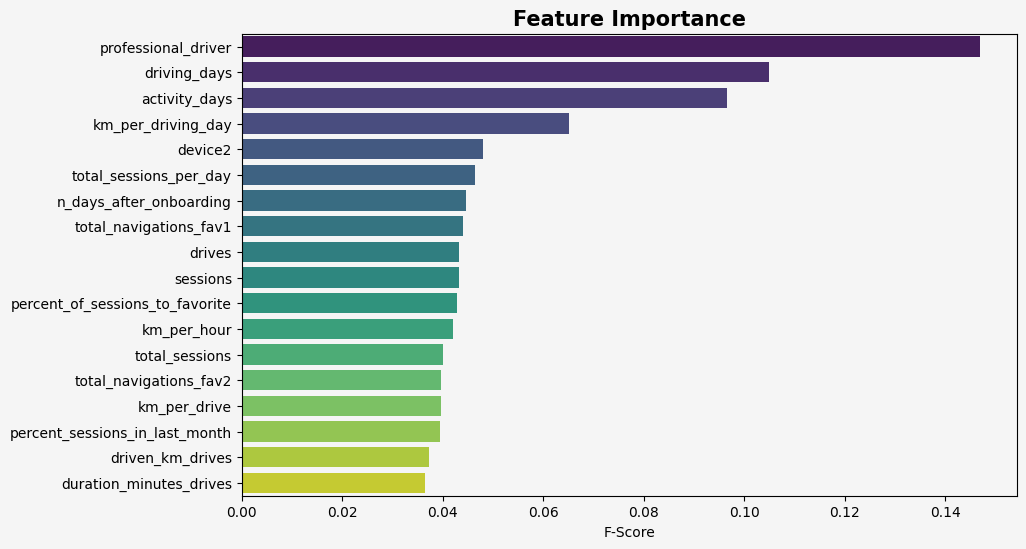

In [52]:
# Generate a nice plot to include in report

importances = xgb_cv.best_estimator_.feature_importances_
feature_names = list(X.columns)

# Sort features by importance in descending order
sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Create a custom bar plot with seaborn and the Viridis colormap
fig, ax = plt.subplots(figsize=(10, 6))
colormap = sns.color_palette("viridis", len(sorted_feature_names))
sns.barplot(x=sorted_importances, y=sorted_feature_names, palette=colormap, ax=ax)

ax.set_facecolor('whitesmoke')
fig.set_facecolor('whitesmoke')

ax.set_xlabel('F-Score')
ax.set_title('Feature Importance', fontweight='bold', fontsize=15)

plt.show()


**FEATURE IMPORTANCE**

The XGBoost model made use of a greater number of the features than did the logistic regression model; the latter weighed a single feature (`activity_days`) very heavily in its final prediction. Engineered variables accounted for six of the top 10 features (and three of the top five). Our feature engineering therefore can be said to have boosted model performance significantly.

Note that the most important features in this stage's model (`total_session_per_day`, `duration_minutes_drives`, `km_per_hou`, `n_days_after_onboarding`, and `total_sessions`) did not include the logistic regression model's most important feature (`activity_days`). These discrepancies between features selected by models are typically caused by complex feature interactions that tree-based models are able to capture better than logistic regressions.

**STAGE 5 SUMMARY**

1. A model with a high recall score is needed to effectively support the retention strategy. Although the gradient boosting machine model performed best in terms of recall, it's score was only between 17.5% and 20.5%. This means that (i) only about 17-20% of users identified by the model actually churn, meaning that at best only 19% of resources spent on retention have a chance of making an effect. It also means that (ii) most users who churn are missed by the model, and thus even those users who are effectively targeted by a retention strategy based on this model are only the minority of users who churn. Thus, I would not recommend this model be used for churn prediction in Waze's retention strategy.

2. The model used is often able to fit the training data extremely well at the risk of overfitting. There would be a chance that having only a training and testing set would produce a champion model that wasn't as good at predicting unseen data as we thought it would be. Thus, I decided to use a validation set as well. However, the cost of using a validation set is that the model had less data on which to train, which increases the chance of the model not fitting the data as well as if no validation set was used. But this cost is heavily outweighed by the benefit of ensuring that a strong champion model is found.

3. Logistic regression models are more easily interpretable, have a much lower training time, and is less prone to overfit the data. In general, it also performs well when there is a clearly linear relationship between independent and target variables, but this dataset did not contain any relationships like this.

4. The biggest advantage of a GBM model over LR is that it can work on a large number of features and identify complex relationships. It is also usually more robust to outliers, can handle missing data, and is usually more predictively accurate due to their ability to capture interactions between features.

5. The model can be improved in at least three simple ways. First, another round of CV can be performed by homing in on the tuning hyperparameters with a more precise focus. Second, the model's performance can be reevaluated by changing the probability threshold for identifying responses. Third, the most important features can be explored further in another round of EDA to see whether there are additional features that can be engineered or relationships identified. However, I don't expect any of these improvements to yeild more than a marginal improvement, which would probably not be worthwhile given that the current best model only stands at a 20% recall at best.

6. A date feature could be useful to see whether churn is seasonal. User age would also be a good predictor, as well as specific locations, or at least the kind of location (urban, suburban, rural, etc.).

**KEY FINDINGS**

The goal of Waze's retention strategy is to identify predictors of churn to improve user experience and grow the business. In order for this strategy to be effective, interventions to increase retention must target users with a high chance of churning. It may be acceptable that these interventions sometimes capture users at a low-risk of churning, so long as (i) this is not a high proporton and (ii) a high enough proportion of high-risk users are also targeted.

Given these considerations:

1. A model with a high recall score was needed.

2. At this stage of the project, we developed a GBM (gradient boosting machine) model to predict user churn. The model's recall lies in the range of 17.5% and 20.5%. This is not satisfactory for deployment.

3. The decision threshold of the model can be optimised for a higher recall (50%). However, this would give us an expected precision of only 30%, meaning that far more retained users will be incorrectly identified as potential churned users.

4. These results confirm findings from earlier stages of the project: more data is needed to satisffactorily predict user churn.
